In [1]:
rm(list = ls())

library(tidyverse)
library(lme4)
library(car)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.2
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘lme4’ was built under R version 3.6.2”
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Warning message:
“package ‘car’ was built under R version 3.6.2”
Loading required package: carData

Warning message:
“package ‘carData’ was built under R version 3.6.2”
Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod     

In [4]:
data.speed.raw <- read_csv("../Data/reading_speed.csv")




Parsed with column specification:
cols(
  id_user = col_double(),
  arial = col_double(),
  avantgarde = col_double(),
  avenir_next = col_double(),
  calibri = col_double(),
  franklin_gothic = col_double(),
  garamond = col_double(),
  helvetica = col_double(),
  lato = col_double(),
  montserrat = col_double(),
  noto_sans = col_double(),
  open_sans = col_double(),
  oswald = col_double(),
  poynter_gothic_text = col_double(),
  roboto = col_double(),
  times = col_double(),
  utopia = col_double()
)



In [23]:
data.speed <- data.speed.raw %>% 
  pivot_longer(-id_user, names_to = 'font', values_to = 'wpm') %>% 
  filter(!is.na(wpm)) %>% 
  group_by(id_user) %>% 
  arrange(id_user, wpm) %>% 
  mutate(
    rank = 0:(n()-1) / 4,
    user_wpm = mean(wpm),
    wpm.z = (wpm - user_wpm) / sd(wpm),
    wpm.adj = wpm - user_wpm
  ) 

In [31]:
print(data.speed)

# A tibble: 1,922 x 7
# Groups:   id_user [386]
   id_user font        wpm  rank user_wpm   wpm.z wpm.adj
     <dbl> <chr>     <dbl> <dbl>    <dbl>   <dbl>   <dbl>
 1       3 arial      228.  0        266. -1.11    -37.9 
 2       3 noto_sans  251   0.25     266. -0.450   -15.4 
 3       3 utopia     256.  0.5      266. -0.289    -9.90
 4       3 calibri    276.  0.75     266.  0.295    10.1 
 5       3 times      320.  1        266.  1.55     53.1 
 6       4 times      374   0        454. -1.08    -79.7 
 7       4 roboto     398   0.25     454. -0.752   -55.7 
 8       4 arial      459   0.5      454.  0.0710    5.27
 9       4 calibri    474   0.75     454.  0.273    20.3 
10       4 noto_sans  564.  1        454.  1.48    110.  
# … with 1,912 more rows


* Transform the data form wide to long format, so there are no empty cells.
* Rank each font by reading speed per user
* Calculate the participant's mean WPM as `user_wpm`
* Calculate a z-transform of the absolute reading speed per participant.
* Calculate a zero-centered WPM metric.

Not all of these ended up being used.

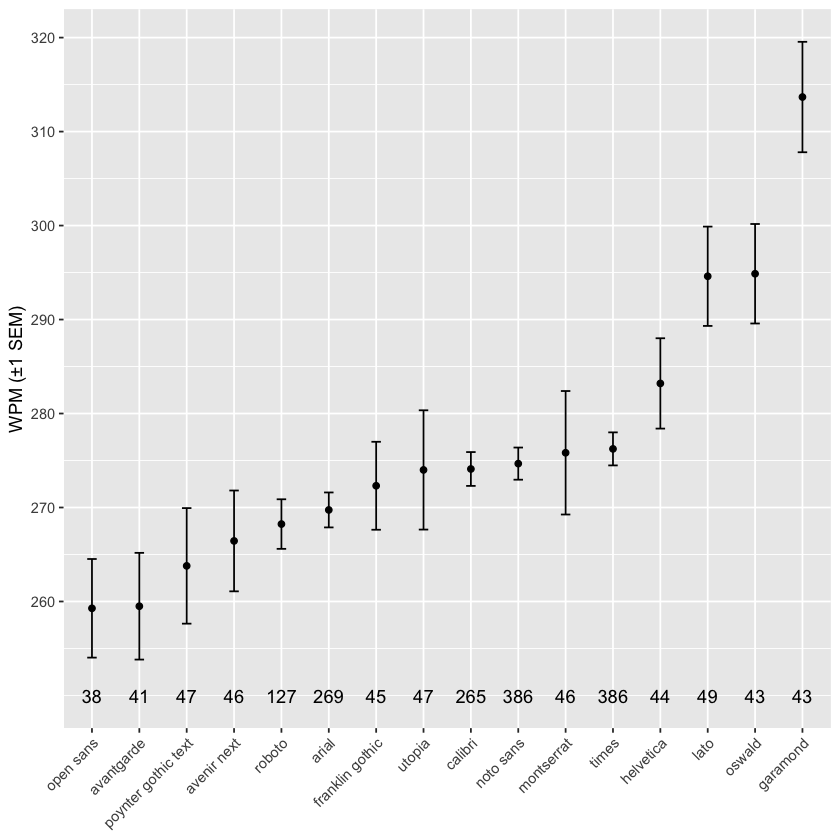

In [12]:
plot.fonts <- data.speed %>% 
  group_by(id_user) %>% 
  mutate(adj.wpm = wpm - mean(wpm)) %>% 
  group_by(font) %>% 
  summarize(
    mean = mean(wpm),
    n = n(),
    adj.se = sd(adj.wpm) / sqrt(n - 1)
  ) %>% 
  arrange(mean) %>% 
  mutate(
    font = gsub('_', ' ', font),
    font = factor(font, unique(font), ordered = T)
  ) %>% 
  ggplot(data = ., aes(x = font, y = mean, ymin = mean - adj.se, ymax = mean + adj.se)) +
  geom_point() +
  geom_errorbar(width = 1/5) +
  geom_text(aes(label = n, y = 250)) +
  scale_y_continuous(breaks = seq(260, 320, 10)) +
  labs(x = NULL, y = 'WPM (±1 SEM)') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
print(plot.fonts)


The plot above shows average reading speeds for each font. Garamond does very well here, but as we'll get into, that may have more to do with the per-participant reading speed than the font itself.

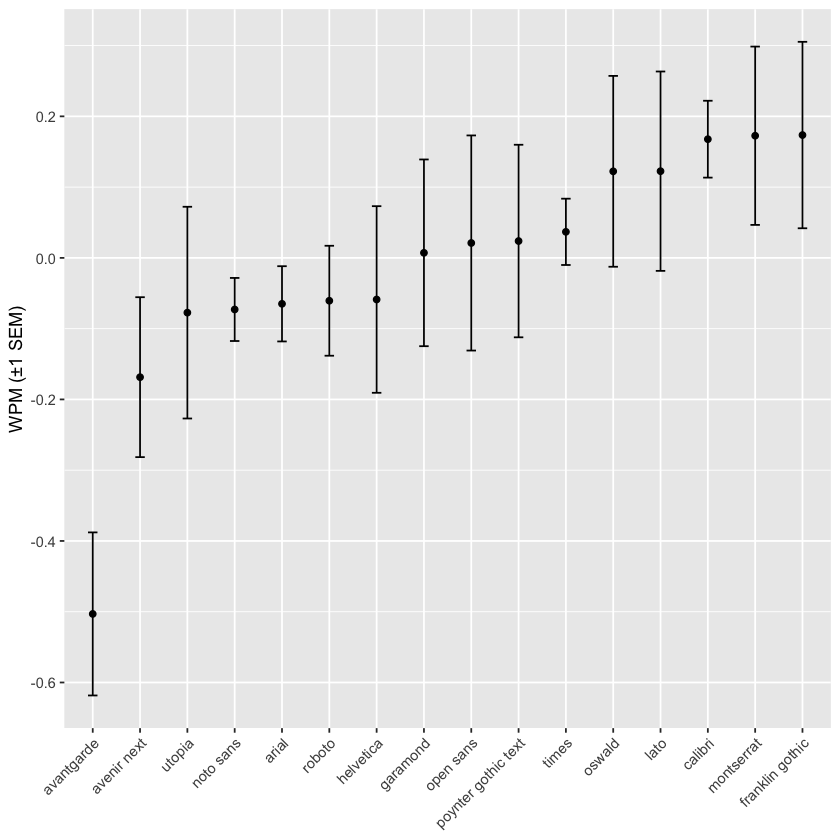

In [15]:
plot.fonts.z <- data.speed %>% 
  group_by(font) %>% 
  summarize(mean = mean(wpm.z), adj.se = sd(wpm.z) / sqrt(n()), n = n()) %>% 
  arrange(mean) %>% 
  mutate(
    font = gsub('_', ' ', font),
    font = factor(font, unique(font), ordered = T)
  ) %>% 
  ggplot(data = ., aes(x = font, y = mean, ymin = mean - adj.se, ymax = mean + adj.se)) +
  geom_point() +
  geom_errorbar(width = 1/5) +
  #geom_text(aes(label = n, y = 250)) +
  #scale_y_continuous(breaks = seq(260, 320, 10)) +
  labs(x = NULL, y = 'WPM (±1 SEM)') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
print(plot.fonts.z)

Here, I've normalized reading speeds per-participant (z-score transform within participant), so you can see which fonts over or under-performed *within* each person. Avant Garde tends to do poorly, while Franklin Gothic does better. But there don't seem to be great differentiators here, and the metric is a little crude. By this metric, Garamond no longer stands out; in fact it's quite close to the per-participant average of performance.

In [16]:
lme.speed <- lmer(wpm ~ font + (1|id_user), data = data.speed)
car::Anova(lme.speed)

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
font,28.26441,15,0.01997132


Above is the simplest linear mixed effects model we can specify for these data. LME models distinguish between fixed and random effects. Fixed effects are usually those that are under experimental control (such as font). Random effects are factors that are not experimentally controlled, such as participant ID. The specification `(1|id_user)` is of the form `(slope|intercept)`. This tells the LME to estimate a different intercept for each user, but keep the slopes the same (since our only within-subject variable is categorical, we can't do per-participant slopes). 

In short, this LME controls for the repeated measures nature of the data. The creation of separate intercepts for each participant should be equivalent to accounting for differences in mean reading speed across participants.

Under this model, font is shown to significantly impact reading speed.

In [27]:
lme.speed.user <- lmer(wpm ~ font + (1|id_user) + (1|user_wpm), data = data.speed)
car::Anova(lme.speed.user) 


boundary (singular) fit: see ?isSingular



,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
font,28.34431,15,0.01951053


A more complex model, which adds the user's average WPM as a random effect. The statistically significant effect of font remains. Though given the highly dependent relationship between `wpm` and `user_wpm`, the model is perhaps a bit dicey. But the model returns similar results if I use the adjusted WPM calculations as the dependent variable. So there does seem to evidence that font matters here.

In [30]:
data.pick <- data.speed %>% 
  ungroup %>% 
  dplyr::select(id_user, user_wpm, font, wpm) %>% 
  mutate(wpm = 1) %>% 
  pivot_wider(names_from = font, values_from = wpm, values_fill = list(wpm = 0)) %>% 
  mutate(reading_group = user_wpm >= median(user_wpm)) %>% 
  pivot_longer(arial:oswald, names_to = 'font', values_to = 'picked') %>% 
  count(font, reading_group, picked) %>% 
  pivot_wider(names_from = reading_group, values_from = n) %>% 
  filter(!(font %in% c('times', 'noto_sans')))

chisq.pick <- data.pick %>% 
  nest(data = c(picked, `FALSE`, `TRUE`)) %>% 
  mutate(p.val = map_dbl(data, function(x) {
    x %>% 
      dplyr::select(-picked) %>% 
      as.matrix %>% 
      chisq.test %>% 
      .$p.value
  }))

print(chisq.pick, n = 20)

# A tibble: 14 x 3
   font                          data  p.val
   <chr>               <list<df[,3]>>  <dbl>
 1 arial                      [2 × 3] 0.376 
 2 avantgarde                 [2 × 3] 1     
 3 avenir_next                [2 × 3] 0.637 
 4 calibri                    [2 × 3] 0.510 
 5 franklin_gothic            [2 × 3] 0.751 
 6 garamond                   [2 × 3] 0.0235
 7 helvetica                  [2 × 3] 0.423 
 8 lato                       [2 × 3] 0.0323
 9 montserrat                 [2 × 3] 0.432 
10 open_sans                  [2 × 3] 0.124 
11 oswald                     [2 × 3] 0.518 
12 poynter_gothic_text        [2 × 3] 1     
13 roboto                     [2 × 3] 0.516 
14 utopia                     [2 × 3] 0.756 


We might also ask whether participants with faster reading speeds were more likely to select certain fonts. In the code above, I split the sample by median `user_wpm` (cutting the participants into fast and slow readers), and then count the frequency of each font. This yields at 2x2 contingency table for each font (fast vs. slow, did or did not select font). A Chi-square test of independence only comes back significant for Garamond and Lato, suggesting that average reading speed of the participant (at least as measured here) did not impact font choice in most cases. Given that 14 tests are run here, the odds of a false positive result are fairly high.

When I re-run the LME models above with Garamond and Lato removed, the same significant effects are preserved.